In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2],
    c2 = [0.5, 2],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = True))

see one see two 2 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c2 = np.max([model.optimizer.C2[1] - ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[0]])
    model.optimizer.c1 = np.min([model.optimizer.C1[0] + ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 100, Accuracy: 0.9320987654320988, Loss: 0.34663931528727215
Checkpoint 200, Accuracy: 0.9753086419753086, Loss: 0.1190134331032082
Checkpoint 300, Accuracy: 0.9753086419753086, Loss: 0.09702722231547038
Checkpoint 400, Accuracy: 0.9753086419753086, Loss: 0.09868440804658113
Checkpoint 500, Accuracy: 0.9753086419753086, Loss: 0.10455120934380426


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.9968528  0.00142835 0.00171886]
[1. 0. 0.] <-> [0.9965798  0.00178776 0.00163247]
[1. 0. 0.] <-> [0.9972898  0.00121025 0.00149994]
[1. 0. 0.] <-> [0.9960155  0.00199481 0.00198968]
[0. 1. 0.] <-> [1.7612336e-02 9.8234713e-01 4.0504583e-05]
[1. 0. 0.] <-> [0.9970125  0.00154923 0.00143821]
[1. 0. 0.] <-> [0.8642932  0.00089324 0.13481349]
[1. 0. 0.] <-> [1.5855132e-02 1.6087888e-05 9.8412871e-01]
[1. 0. 0.] <-> [0.9877824  0.01072282 0.00149471]
[1. 0. 0.] <-> [0.99299026 0.00113776 0.00587189]
[1. 0. 0.] <-> [0.9962715  0.00229053 0.00143795]
[1. 0. 0.] <-> [0.9697655  0.00126961 0.02896495]
[1. 0. 0.] <-> [0.9970656  0.00124729 0.0016871 ]
[1. 0. 0.] <-> [0.99129313 0.00104288 0.00766406]
[1. 0. 0.] <-> [0.9960169  0.0025702  0.00141287]
[0. 0. 1.] <-> [4.9010399e-01 4.9909804e-04 5.0939691e-01]
[1. 0. 0.] <-> [0.99704117 0.00120614 0.00175262]
[1. 0. 0.] <-> [0.9959848  0.00138126 0.00263387]
[1. 0. 0.] <-> [0.9921171  0.00642995 0.00145291]
[0. 1. 0.] <-> [6.02642

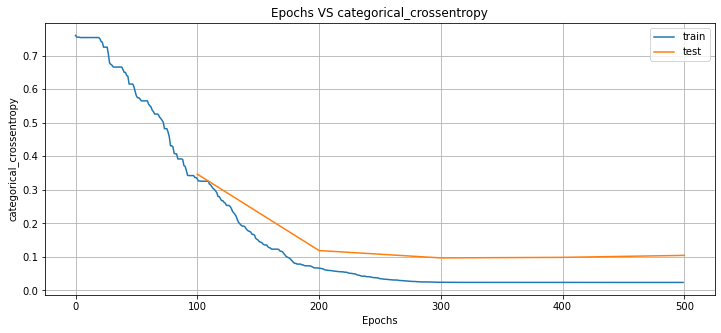

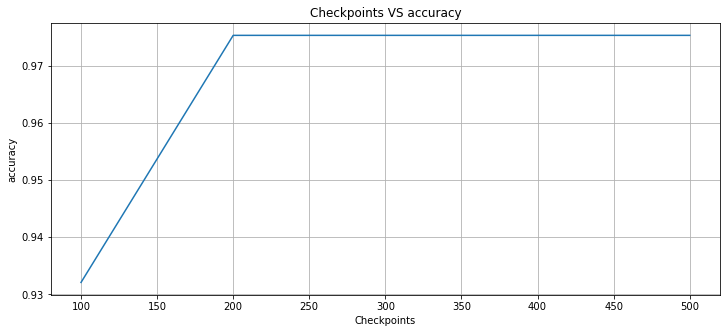

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9320987654320988, 'mean_square_error': 0.18691160623775913, 'categorical_crossentropy': 0.34663931528727215, 'essential_metrics': {0: {'tp_hit': 74, 'fp_hit': 5, 'tn_hit': 23, 'fn_hit': 6}, 1: {'tp_hit': 12, 'fp_hit': 3, 'tn_hit': 90, 'fn_hit': 3}, 2: {'tp_hit': 11, 'fp_hit': 3, 'tn_hit': 92, 'fn_hit': 2}}, 'checkpoint': 100} 


{'accuracy': 0.9753086419753086, 'mean_square_error': 0.061548920937510285, 'categorical_crossentropy': 0.1190134331032082, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 2, 'tn_hit': 26, 'fn_hit': 2}, 1: {'tp_hit': 15, 'fp_hit': 1, 'tn_hit': 92, 'fn_hit': 0}, 2: {'tp_hit': 11, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit': 2}}, 'checkpoint': 200} 


{'accuracy': 0.9753086419753086, 'mean_square_error': 0.05090269251781599, 'categorical_crossentropy': 0.09702722231547038, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 1, 'tn_hit': 27, 'fn_hit': 3}, 1: {'tp_hit': 14, 'fp_hit': 1, 'tn_hit': 92, 'fn_hit': 1}, 2: {'tp_hit': 13, 'fp_hit': 2, 'tn_hit': 93,

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[-0.5165815   3.          0.56030214  0.21182571 -3.        ]
 bias: 3.0

Neuron 1: weights:
[ 1.9286287  -3.         -3.         -0.87023145  2.3295858 ]
 bias: 3.0

Neuron 2: weights:
[ 0.29510516  3.          0.8356308  -3.         -3.        ]
 bias: 2.5348622798919678

Neuron 3: weights:
[ 2.0201066  -3.         -1.5077349  -0.22401376  2.4538767 ]
 bias: 3.0

$
Layer 2
Neuron 0: weights:
[3. 3. 3. 3.]
 bias: -3.0

Neuron 1: weights:
[ 3. -3.  3. -3.]
 bias: 2.1055750846862793

Neuron 2: weights:
[-3.         3.        -3.         2.2410202]
 bias: 3.0

$

